<h1>Words Size Regression - Modèle Dense</h1>
<br>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!mkdir database
! mkdir database/ascii
! tar xzf drive/MyDrive/ocr/database/ascii.tgz -C database/ascii

! mkdir database/words
! tar xzf drive/MyDrive/ocr/database/words.tgz -C database/words

! mkdir database/images_test
! cp -r drive/MyDrive/ocr/database/images_test/* database/images_test/

! cp drive/MyDrive/ocr/src/streamlit/importation.py importation.py
! cp drive/MyDrive/ocr/src/streamlit/preprocessor_2.py preprocessor_2.py
! cp drive/MyDrive/ocr/src/streamlit/wsmodel.py wsmodel.py

! mkdir models
! cp drive/MyDrive/ocr/models/* models/

In [1]:
from importation import Importation

from preprocessor import Preprocess
import wsmodel
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

# Importation des données - preprocessing

In [7]:
imp = Importation('database')
df = imp.get_words().sample(frac=1, random_state=1).reset_index()
# n_lettres_max=11
# df = df[df.word_size<=n_lettres_max][['file', 'word_size', 'label']]
df.word_size = df.word_size.astype('float32')
print("Nombre d'enregistrements ", df.shape[0])


df = df[['file', 'word_size', 'label']]
df.info()
image_width = 128
image_height = 32
batch_size = 64
img_size = (image_width, image_height)
prepro = Preprocess(img_size, batch_size=batch_size, gaussianBlur=True)

df_train, df_valid, df_test = prepro.split_data(df, train_size=0.9)

x_train, y_train = df_train["file"].values, df_train["word_size"].values
x_test, y_test = df_test["file"].values, df_test["word_size"].values
x_valid, y_valid = df_valid["file"].values, df_valid["word_size"].values

train_ds = prepro.prepare_dataset_word_size(x_train, y_train)
validation_ds = prepro.prepare_dataset_word_size(x_valid, y_valid)
test_ds = prepro.prepare_dataset_word_size(x_test, y_test)



Nombre d'enregistrements  96454
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96454 entries, 0 to 96453
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file       96454 non-null  object 
 1   word_size  96454 non-null  float32
 2   label      96454 non-null  object 
dtypes: float32(1), object(2)
memory usage: 1.8+ MB
initialisation


# Chargement du modèle

In [3]:
#import importlib
#import sys
#importlib.reload(sys.modules['wsmodel']) 


train = False
#model = wsmodel.create_model_lenet(image_width, image_height)
#model = wsmodel.create_model_cnn(image_width, image_height)
model = wsmodel.create_model_dense(image_width, image_height)
if train:
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
model.summary()

Model: "Dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 512)               2097664   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,229,249
Trainable params: 2,229,249
Non-trainable params: 0
_________________________________________________________________


# Entraînement du modèle 

Epoch 1/50
1357/1357 [==============================] - 280s 206ms/step - loss: 2.4607 - mean_absolute_error: 1.1352 - val_loss: 2.1106 - val_mean_absolute_error: 1.0434
Epoch 2/50
1357/1357 [==============================] - 3s 2ms/step - loss: 2.1454 - mean_absolute_error: 1.0457 - val_loss: 1.9546 - val_mean_absolute_error: 0.9886
Epoch 3/50
1357/1357 [==============================] - 3s 2ms/step - loss: 2.0294 - mean_absolute_error: 1.0105 - val_loss: 1.9165 - val_mean_absolute_error: 0.9756
Epoch 4/50
1357/1357 [==============================] - 3s 2ms/step - loss: 1.9556 - mean_absolute_error: 0.9883 - val_loss: 1.8198 - val_mean_absolute_error: 0.9571
Epoch 5/50
1357/1357 [==============================] - 3s 2ms/step - loss: 1.8916 - mean_absolute_error: 0.9705 - val_loss: 1.7882 - val_mean_absolute_error: 0.9476
Epoch 6/50
1357/1357 [==============================] - 3s 2ms/step - loss: 1.8335 - mean_absolute_error: 0.9547 - val_loss: 1.7659 - val_mean_absolute_error: 0.9402


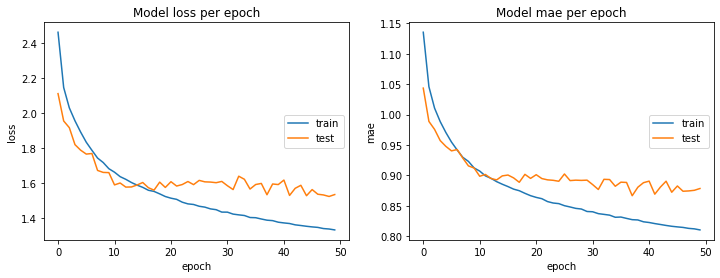

In [4]:
if train:
    epochs = 50
    training_history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        verbose=1
    )

    train_loss = training_history.history["loss"]
    val_loss = training_history.history["val_loss"]
    train_acc = training_history.history["mean_absolute_error"]
    val_acc = training_history.history["val_mean_absolute_error"]
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Model loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')

    plt.subplot(122)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Model mae per epoch')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')
    model.save_weights("models/word_size_dense.h1")

else: 
    model.load_weights("models/word_size_dense.h1")

# Prédictions

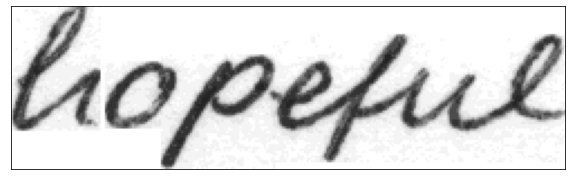

Label     : hopeful
Word size     : 7
Prédiction:  8.36


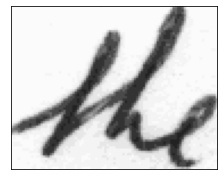

Label     : the
Word size     : 3
Prédiction:  3.38


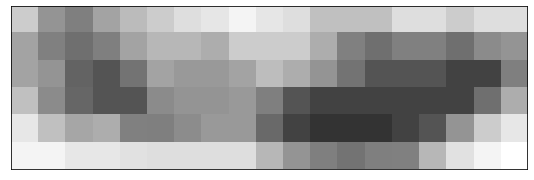

Label     : -
Word size     : 1
Prédiction:  2.87


In [5]:


# Création d'un dataset pour une image unique
def get_ds(img_path, word_size):
    x = np.array([img_path])
    y = np.array([word_size])
    ds = prepro.prepare_dataset_word_size(x, y)
    return ds

def get_prediction(ds):
    errors = []
    output_word_size = []
    for batch in ds:
        word_size = batch[1] 
        batch_images = batch[0]
        #batch_images = tf.transpose(batch[0], [0,2,1,3])
        preds = model.predict(batch_images, verbose=0)
        output_word_size += [v[0] for v in preds.tolist()]
    return output_word_size


files = []
labels = []
predictions = []
distances = []
df_predict = df_test
for i in np.random.choice(np.arange(0, len(df_predict)), size=3):  
  label = df_predict.iloc[i].label
  word_size = df_predict.iloc[i].word_size
  img_path = df_predict.iloc[i].file
  ds = get_ds(img_path, word_size)
  prediction= get_prediction(ds)
  prediction = np.round(prediction,2)[0]
  image = cv2.imread(img_path)
  plt.figure(figsize=(10,3))
  plt.imshow(image, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print(f"Label     : {label}")
  print(f"Word size     : {int(word_size)}")
  print("Prédiction: ",prediction)


## Prédiction sur l'ensemble de test

In [6]:
ds = test_ds
output = get_prediction(ds)

        
df_result = pd.DataFrame({'file' : df_test.file,
                          'label': df_test.label,
                          'word_size' : df_test.word_size,
                          'prediction' : output,
                         })

df_result['error'] = np.round(np.abs((df_result['word_size'] -  df_result['prediction'])),2)

print(f"Erreur Moyenne : {df_result.error.mean()}")
print(df_result.error.describe())
df_result.drop("file", axis=1).head(20)

Erreur Moyenne : 0.8747397885133736
count    4823.000000
mean        0.874740
std         0.895765
min         0.000000
25%         0.250000
50%         0.590000
75%         1.170000
max         7.900000
Name: error, dtype: float64


,label,word_size,prediction,error
91631,swift,5.0,3.958129,1.04
91632,Betti's,7.0,7.493505,0.49
91633,like,4.0,3.762755,0.24
91634,unceasing,9.0,8.975956,0.02
91635,Fell,4.0,2.458233,1.54
91636,Morfydd,7.0,7.330547,0.33
91637,in,2.0,2.456373,0.46
91638,unguarded,9.0,10.363960,1.36
91639,was,3.0,4.428610,1.43
91640,&,1.0,2.014445,1.01
